# Object Detection Demo: Car Detection

This is a sample reference implementation to showcase Object detection (car in this case) with SSD and Async API.
Async API improves the overall frame-rate of the application by not waiting for the inference to complete but continue doing things ont he host while accelerator is busy. 
Specifically, this code demonstrates two parallel infer requests by processing the current frame while the next input frame is being captured. This essentially hides the latency of capturing.

## Overview of How it works?
At start-up the sample application reads the equivalent of command line arguments  and loads a network and image from the video input to the Inference Engine (IE) plugin. 
A job is submitted to the hardware accelerator (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Core CPU, Intel® Movidius™ and/or Neural Compute Stick)
After the inference is completed, the output videos are appropriately stored in the /results directory which can then be viewed within the Jupyter Notebook instance

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed actual Edge hardware
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes
* Demonstrate the Async API in action


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import some dependencies needed for displaying the results in this notebook
(tip: use **crtl+enter** to run the cell but stay on the same cell)

In [1]:
from demoutils import videoHTML,liveQstat
from IPython.display import HTML
import matplotlib.pyplot as plt

### 0.2  (Optional-step): Original video without inference

If the user is curious to see the input video, run the following cell to view the orignal video used for inference and object detection.

In [ ]:
!ln -s /data/reference-sample-data/object-detection-python/cars_1900.mp4 
videoHTML('cars video', 'cars_1900.mp4')

## Step 1: Using OpenVINO

Let's first try running inference on a single image to see how OpenVINO works.
We will be using OpenVINO's Inference Engine (IE) to locate vehicles on the road.
There are five steps:

1. Create a Intermediate Representation (IR) Model using the Intel Model Optimizer
2. Choose a device and create IEPlugin for the device
3. Read the IRModel using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Creating IR Model

Intel Model Optimizer creates Intermediate Representation (IR) models that are optimized for different Intel hardware.
These models can be created from existsing DNN models from popular frameworks (e.g. Caffe, TF) using the Intel Model Optimizer. 

There is a utility script `model_downloader.py` to download some common modes. Run the following cel to see the models available through `model_downloader.py`

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/downloader.py --print_all

**Note** the '!' is a special Jupyter Notebook command that allows you to run shell commands as if you are in commannd line. So the above command will work straight out of the box on in a terminal (with '!' removed).

We will be using the **mobilenet-ssd** model. This can be download with the following command.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/downloader.py --name mobilenet-ssd -o raw_models

The input arguments are as follows:
* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will create it for you.

There are more arguments to this script: you can get the full list using the `-h` option.


With the `-o` option set as above, this command download the model in the directory `raw_models`, with the `.caffemodel` located at `raw_models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel`

Let's now convert this to the optimized model using the model optimizer.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model raw_models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel \
--data_type FP32 \
-o models/mobilenet-ssd/FP32

**Note** the above line is a single command line input, which spans 4 lines thanks to '\'.

Here the arguments are:
* --input-model : the original model
* --data_type : Data type to use. One of {FP32, FP16, half, float}
* -o : outout dirctory

This script also supports `-h` that will you can get the full list of arguments.

With the `-o` option set as above, this command will write the output to the directory `models/mobilenet-ssd/FP32`

There are two files:
```
models/mobilenet-ssd/FP32/mobilenet-ssd.xml
models/mobilenet-ssd/FP32/mobilenet-ssd.bin
```
These will be used later in the exercise.

We will also be needing the FP16 version of the model for the MYRIAD runs. Run the dfollowing cell to create it.

In [ ]:
!/opt/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo.py \
--input_model raw_models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel \
--data_type FP16 \
-o models/mobilenet-ssd/FP16

### 1.2 Choosing Device

Now we must select the device used for the inferencing. This is done by loading the appropriate plugin to initialize the specified device and load the extensions library (if specified) provided in the extension/ folder for the device.


The following cell constructs **`IEPlugin`**:

In [2]:
from openvino.inference_engine import IEPlugin, IENetwork

def createPlugin(device, extension_list):
    # Plugin initialization for specified device. We will be targeting CPU initially.
    plugin = IEPlugin(device='CPU')

    # Loading additional exension libraries for the CPU
    for extension in extension_list:
        plugin.add_cpu_extension('/data/reference-sample-data/extension/libcpu_extension.so')
    
    return plugin

**Note**
Currently, three types of plugins are supported: CPU, GPU, and MYRIAD. CPU plugin may require additional extensions to improve performance, abd `add_cpu_extension` function is used to load these additional extensions.


### 1.3 Read the IR (Intermediate Representation) model

We can import optimized models (weights) from step 1.1 into our neural network using **`IENetwork`**. 


In [3]:
def createNetwork(model_xml, model_bin, plugin):
    # Importing network weights from IR models.

    net = IENetwork.from_ir(model=model_xml, weights=model_bin)

    # Some layers in IR models may be unsupported by some plugins. 
    if "CPU" in plugin.device:
        supported_layers = plugin.get_supported_layers(net)
        not_supported_layers = [l for l in net.layers.keys() if l not in supported_layers]
        if len(not_supported_layers) != 0:
            print("Following layers are not supported by the plugin for specified device {}:\n {}".
                      format(plugin.device, ', '.join(not_supported_layers)))
            print("Please try to specify cpu extensions library path in sample's command line parameters "
                  "using -l or --cpu_extension command line argument")
            return None
    return net

**Note**
Some models may be incompatible with some target devices. For example, some types of neural network layers are not supported on the CPU. 

### 1.4 Load the network on to the model

Once we have the plugin and the network, we can load the network into the plugin using **`plugin.load`**.

In [4]:
def loadNetwork(plugin, net):
    # Loading IR model to the plugin.
    exec_net = plugin.load(network=net, num_requests=2)
    
    # Getting the input and outputs of the network
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    return exec_net,input_blob,out_blob


### 1.5 Run inference

Now we are ready to try running the inference workload using the plugin.
First let's load the image using OpenCV.
We will also have to do some shape manipulation to convert the image to a format that is compatible with our network


In [5]:
import cv2

def preprocessImage(img_path, net, input_blob):
    # Reading the frame from a jpeg file
    frame = cv2.imread(img_path)
    
    # Reshaping data
    n, c, h, w = net.inputs[input_blob]
    in_frame = cv2.resize(frame, (w, h))
    in_frame = in_frame.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    return in_frame.reshape((n, c, h, w)),frame

For the inference, we will be running in **async_mode** by using `start_async` method. 
With the async_mode, the inference is started in parallel on either a separate thread or device.
In other words, `start_async` is non-blocking and the main process is free to do any additional processing needed. 
In the next section, we will see an implementation of pipelining to mask the latency of loading and modifying images.

During asynchronous runs, the different images are tracked by an integer `request_id`. 
Because we only have one image to process, we will just use 0.

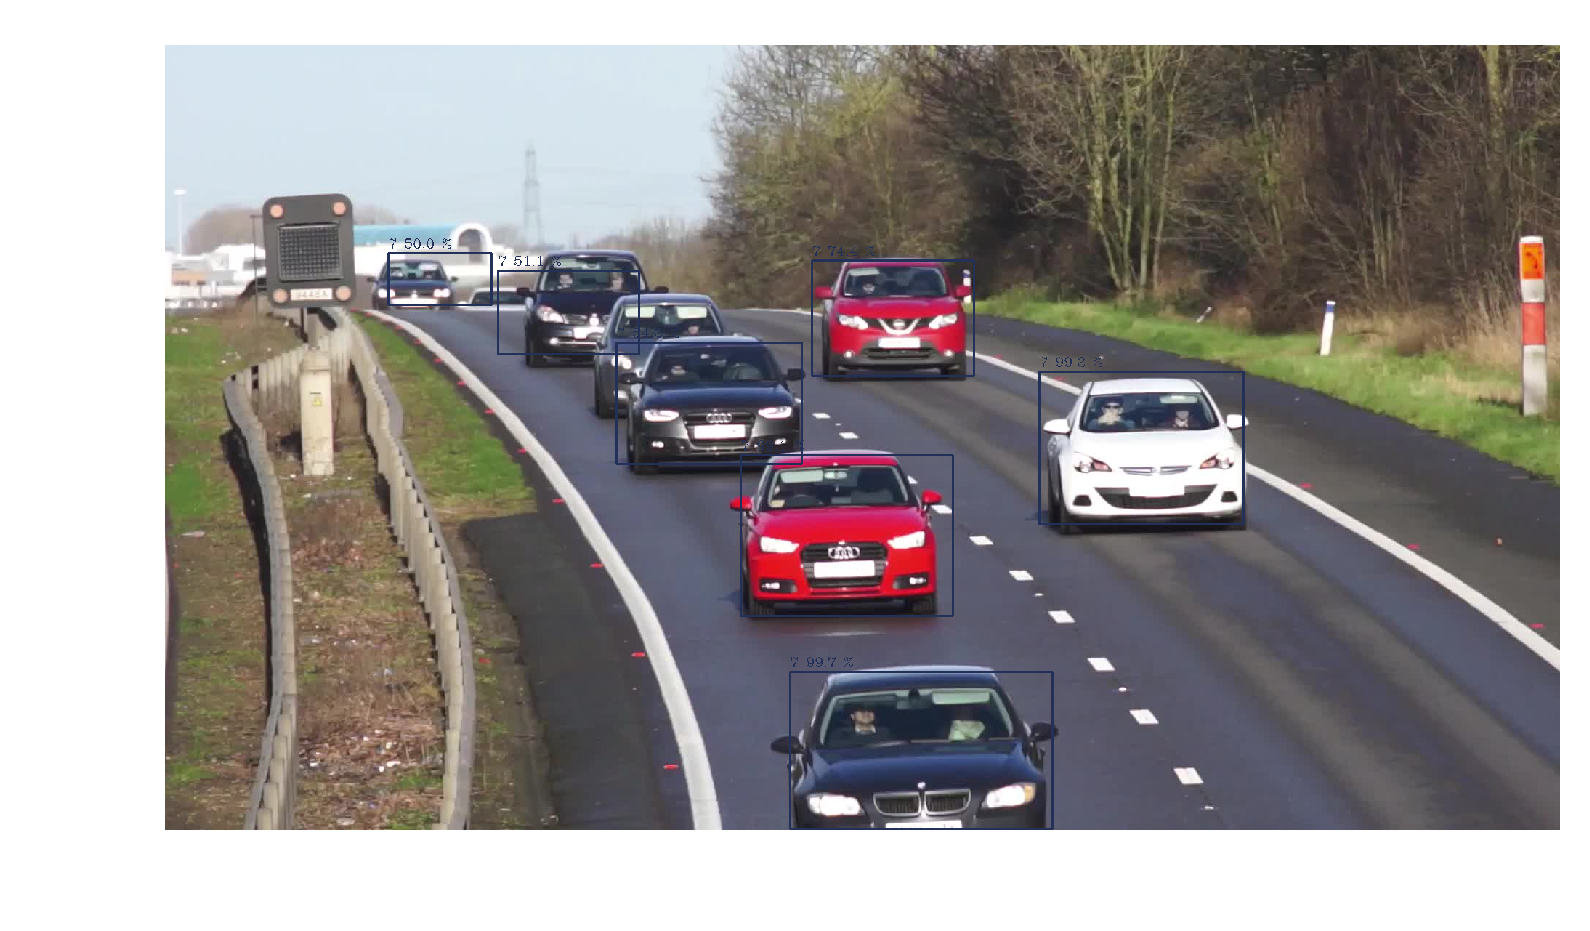

In [15]:
# For labeling the image
from object_detection_demo_ssd_async import placeBoxes

# Request id to keep track of
def runInference():
    plugin = createPlugin(device='CPU', extension_list=['/data/reference-sample-data/extension/libcpu_extension.so'])
    #model_xml = "models/mobilenet-ssd/FP32/mobilenet-ssd.xml"
    #model_bin = "models/mobilenet-ssd/FP32/mobilenet-ssd.bin"
    model_xml = "/data/reference-sample-data/models/mobilenet-ssd/FP32/mobilenet-ssd.xml"
    model_bin = "/data/reference-sample-data/models/mobilenet-ssd/FP32/mobilenet-ssd.bin"
    net = createNetwork(model_xml, model_bin, plugin)
    exec_net,input_blob,out_blob = loadNetwork(plugin, net)
    in_frame,original_frame = preprocessImage('cars_1900_first_frame.jpg', net, input_blob)
    
    my_request_id=0

    # Starting the inference in async mode, which starts the inference in parallel
    exec_net.start_async(request_id=my_request_id, inputs={input_blob: in_frame})
    # ... You can do additional processing or latency masking while we wait ...

    # Blocking wait for a particular request_id
    if exec_net.requests[my_request_id].wait(-1) == 0:
        # getting the result of the network
        res = exec_net.requests[my_request_id].outputs[out_blob]

        # Processing the output result and adding labels on the image. Implementation is not shown in the
        #  this notebook; you can find it in object_detection_demo_ssd_async.py
        prob_threshold = 0.5  # 50% confidence needed for "detection"
        initial_w = original_frame.shape[1]
        initial_h = original_frame.shape[0]
        frame = placeBoxes(res, None, prob_threshold, original_frame, initial_w, initial_h)
        
        # We use pyplot because it plays nicer with Jupyter Notebooks
        fig = plt.figure(dpi=300)
        ax = fig.add_subplot(111)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation='none')
        plt.axis("off")
        plt.show()
    else:
        print("There was an error with the request")
runInference()

## Step 2 : Inference on a video

Now that we know how to run inference on a single frame, let's extend this to multiple frames.
This part is already implemented in [object_detection_demo_ssd_async.py](object_detection_demo_ssd_async.py).
Most of the code is just an extension of the single frame example, but there are few sections of note that we highlight here.

The following lines determine the source of video. We will use pre-recorded input video file in this example, but it can be modified to use a camera with input argument 'cam'.
```python
if args.input == 'cam':
        input_stream = 0
        out_file_name = 'cam'
    else:
        input_stream = args.input
```
We capture frames from the video sample using **OpenCV VideoCapture** API.

```python
cap = cv2.VideoCapture(input_stream)
```

Finally, we have a latency masking scheme where we post-process the frames while another is being processed on the inference engine.

```python
cur_request_id = 0
next_request_id = 1

while cap.isOpened():
   # ... load next frame from cap ...

   # start the next frame
   exec_net.start_async(request_id=next_request_id, inputs={input_blob: in_frame})

   # see if the current frame is ready
   if exec_net.requests[cur_request_id].wait(-1) == 0:
       # ... post processing current frame ...
    
   # swap request ids
   cur_request_id, next_request_id = next_request_id, cur_request_id
```

The python code takes in command line arguments for video, model etc.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH="/data/reference-sample-data"
python3 object_detection_demo_ssd_async.py -m ${SAMPLEPATH}/models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i ${SAMPLEPATH}/object-detection-python/cars_1900.mp4 \
                                           -o $1 \
                                           -d $2 \
                                           -l ${SAMPLEPATH}/extension/libcpu_extension.so
```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the **mobilenet-ssd** pre-trained model which has been pre-processed using the **model optimzer**
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, OpenVINO's Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, MxNet* etc.,)    

* -i location of the input video stream (video/cars_1900.mp4)
* -o location where the output file with inference needs to be stored. (results/core or results/xeon or results/gpu)
* -d Type of Hardware Acceleration (CPU or GPU or MYRIAD)
* -l Absolute path to the shared library and is currently optimized for core/xeon (extension/libcpu_extension.so )

### 2.1 Creating job file

All the code up to this point is run within the notebook instance running on the Developer machine. 
But to run inference on the entire video, we need more compute power.
We will run the workload on an actual Edge Machine by creating a job to be submitted on a queue to run on the first available Edge hardware that matches the user choice.

The job file is written in bash, and will be executed directly on the compute node.
For this example, we have written the job file for you in the notebook.
Run the following cell to write this in to the file "object_detection_job.sh"

In [ ]:
%%writefile object_detection_job.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
#  The output directory is the first argument of the bash script
mkdir -p $1

# Running the object detection code
SAMPLEPATH="/data/reference-sample-data"
python3 object_detection_demo_ssd_async.py -m ${SAMPLEPATH}/models/mobilenet-ssd/$3/mobilenet-ssd.xml \
                                           -i ${SAMPLEPATH}/object-detection-python/cars_1900.mp4 \
                                           -o $1 \
                                           -d $2 \
                                           -l ${SAMPLEPATH}/extension/libcpu_extension.so

### 2.2 Understand how job queue is submitted

Now that we have the job script, we can submit the jobs to compute nodes using the `qsub` command.
We can submit object_detection_job to 4 different types of nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option lets us send arguments to the bash script. 
- `-N` : this option lets use name the job so that it is easier to distinguish between them.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [ ]:
!pbsnodes | grep properties | sort | uniq -c

Here, the properties describe the node, and number on the left is the number of available nodes.

### 2.3 Job queue submission

Each of the next 4 cells below will submit jobs to different nodes Core/Xeon/GPU or Myriad .
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all 4 jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

#### submitting to a node with Intel Core CPU

In [ ]:
!qsub object_detection_job.sh -l nodes=1:iei-tank-core -F "results/core CPU FP32" -N obj_det_core

#### submitting to a node with Intel Xeon CPU

In [ ]:
!qsub object_detection_job.sh -l nodes=1:iei-tank-xeon -F "results/xeon CPU FP32" -N obj_det_xeon

#### submitting to a node with Intel Core CPU and using the onboard Intel GPU

In [ ]:
!qsub object_detection_job.sh -l nodes=1:iei-tank-core -F "results/gpu GPU FP32" -N obj_det_gpu

#### submitting to a node with Intel Movidius NCS (Neural Computing Stick)

In [ ]:
!qsub object_detection_job.sh -l nodes=1:iei-tank-movidius -F "results/myriad MYRIAD FP16" -N obj_det_myriad

### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use the `qstat` command.

We have created a custom Jupyter widget  to get live qstat update.
Run the following cell to bring it up. 

In [ ]:
liveQstat()

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 2.3).
There should also be an extra job: this is your current jupyter notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.
**Note** currently it takes a anywhere from 3-5 minutes depending on the number of users accessing the edge nodes.

## Step 3: View Results

Once the jobs are completed, the stdout and stderr output stores in files with names of the form (based on our `-N` option):

`obj_det_{type}.o{JobID}`

`obj_det_{type}.e{JobID}`

But for this script, the main output is the mp4 videos which are stored in the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
See `demoutils.py` if interested in understanding further how the results are displayed in notebook.


In [ ]:
videoHTML('IEI Tank (Intel Core CPU)', 'results/core/cars_1900.mp4', 'results/core/stats.txt')

In [ ]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)','results/xeon/cars_1900.mp4','results/xeon/stats.txt')

In [ ]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 'results/gpu/cars_1900.mp4','results/gpu/stats.txt')

In [ ]:
videoHTML('IEI Tank + Myriad (Intel Core + Movidius)','results/myriad/cars_1900.mp4','results/myriad/stats.txt')